In [30]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import warnings
warnings.filterwarnings("ignore")

In [2]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

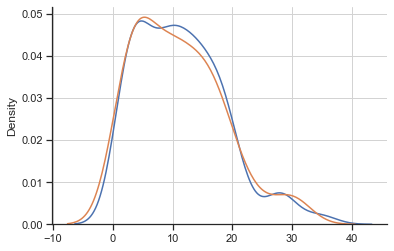

In [212]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from survivors.experiments.grid import generate_sample, prepare_sample, count_metric

# X, y, features, categ, sch_nan = ds.load_actg_dataset()
# X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
X, y, features, categ, sch_nan = ds.load_wuhan_dataset()

qs = np.quantile(y["time"], np.linspace(0.2, 0.8, 4))
time_discr = np.searchsorted(qs, y["time"])

discr = np.char.add(time_discr.astype(str), y["cens"].astype(str))
X_TR, X_HO = train_test_split(X, stratify=discr, test_size=0.33, random_state=42)
X_tr, y_tr, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)

df = X_HO.copy()
df["time"] = y_HO["time"]
df["cens"] = y_HO["cens"]

df_tr = X_tr.copy()
df_tr["time"] = y_tr["time"]
df_tr["cens"] = y_tr["cens"]

sns.kdeplot(y_tr["time"], label="train")
sns.kdeplot(y_HO["time"], label="HO")
plt.show()

<Axes: ylabel='Density'>

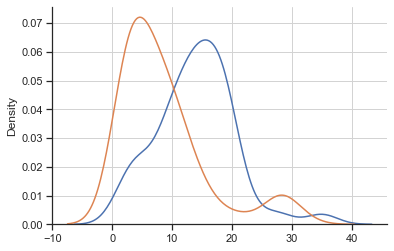

In [213]:
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 0)[0]]["time"], label="train")
sns.kdeplot(y_tr[np.where(y_tr["cens"] == 1)[0]]["time"], label="train")

(0.0, 2029.0)

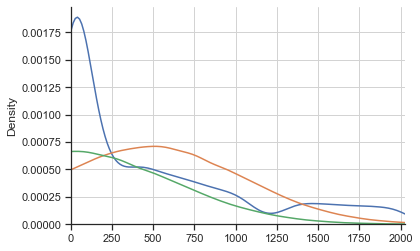

In [255]:
import scipy.stats as stats
from scipy.optimize import root, fsolve

def equations(l_var, mu_e, sigma_e):
    mu, sigma = l_var
    alpha = -mu/sigma
    phi_a = 1/np.sqrt(2*np.pi) * np.exp(-1/2*(alpha**2))
    Z = 1 - stats.norm.cdf(alpha)
    eq1 = mu + phi_a * sigma / Z - mu_e + (mu < 0)*1e4
    eq2 = ((sigma / sigma_e)**2) * (1 + alpha*phi_a/Z - (phi_a/Z)**2) - 1 + (sigma_e < 0)*1e4
    return [eq1, eq2]


class TruncNorm:
    _ctor_param = {"name": "TruncNorm"}
    @staticmethod
    def fit(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        
        solution = fsolve(equations, [mu_e, sigma_e], args=(mu_e, sigma_e))
        return solution
#         solution = root(lambda x: equations(x, mu_e, sigma_e), [mu_e, sigma_e])
#         print("Solution:", solution.x)
#         return solution.x

    @staticmethod
    def rvs(mu, sigma, size, random_state=42):
        return stats.norm.rvs(mu, sigma, size=size, random_state=random_state)
    
    @staticmethod
    def valid(y):
        mu_e = np.mean(y)
        sigma_e = np.std(y)
        
        params = TruncNorm.fit(y)
        a = TruncNorm.rvs(*params, size=100000, random_state=42)
        a = a[a > 0]
        print(mu_e, np.mean(a))
        print(sigma_e, np.std(a))
        

sns.kdeplot(y_["time"])
for st in [stats.norm, TruncNorm, 
#            stats.lognorm, stats.gamma, stats.laplace, stats.laplace_asymmetric, 
#            stats.rayleigh, stats.weibull_min, stats.genlogistic
          ]:
    params = st.fit(y_["time"])
    sns.kdeplot(st.rvs(*params, size=100000, random_state=42))
plt.xlim((0, y_["time"].max()))

In [256]:
equations([1.5, 599], np.mean(y_["time"]), np.std(y_["time"]))

[0.028469187450241407, -0.5841423088898394]

In [257]:
TruncNorm.fit(y_["time"])

array([  1.35990369, 599.02923262])

In [258]:
TruncNorm.valid(y_["time"])
# TruncNorm.valid(y_tr["time"])

478.44986271279515 478.6355181767582
560.3524982368881 361.7686781308691


### Informative censuring comparison

In [259]:
from survivors.external.nonparametric import KaplanMeier

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

df = X.copy()
df["time"] = y["time"]
df["cens"] = y["cens"]

SF IBS:0.19145, AUPRC:0.58663
SF1 IBS:0.17696, AUPRC:0.64852
SF2 IBS:0.17813, AUPRC:0.64291


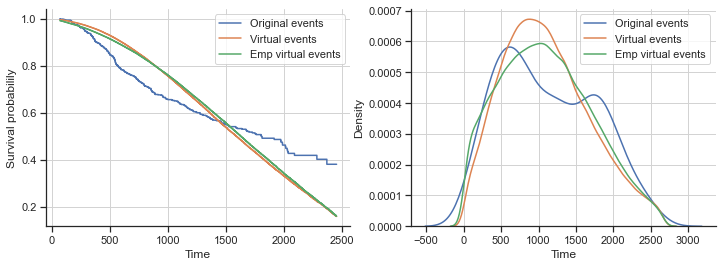

In [260]:
def med_std(x):
    N = len(x)
    d2 = abs(x - np.median(x))**2  # abs is for complex `a`
    var = np.sum(d2) / N  # note use of `ddof`
    return var**0.5

class KaplanMeierZeroAfter(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.array(durations)
        self.events = np.array(right_censor)
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        # place_bin = np.digitize(times, self.timeline)  # -1
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterTh(KaplanMeier):
    def __init__(self, d_type, *args, **kwargs):
        self.d_type = d_type
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
#         q1, q2 = np.quantile(durations, [0.05, 0.95])
        params = self.d_type.fit(durations)
#         params = self.d_type.fit(durations[right_censor == 1])
#         params = list(params)
#         params[1] = params[1] / np.sqrt(1.5)
        self.durs = self.d_type.rvs(*params, size=100000, random_state=42)
        self.events = np.random.choice(right_censor, size=100000, replace=True)
#         self.durs = np.hstack([durations.copy(), self.durs])
#         self.events = np.hstack([right_censor.copy(), self.events])

        ind = (self.durs >= durations.min()) & (self.durs <= durations.max())
#         ind = (self.durs >= q1) & (self.durs <= q2)
        self.events = self.events[ind]
        self.durs = self.durs[ind]
        super().fit(self.durs, self.events)

    def survival_function_at_times(self, times):
        place_bin = np.searchsorted(self.timeline, times)
        sf = self.survival_function[np.clip(place_bin, 0, None)]
        sf[times > self.timeline[-1]] = 0
        sf[times <= self.timeline[0]] = 1
        return sf
    
class KaplanMeierZeroAfterEmp(KaplanMeierZeroAfter):
    """
    Nonparametric model with virtual events generated by bootstrap meaning
    """
    def __init__(self, n=2, *args, **kwargs):
        self.n = n
        super().__init__(*args, **kwargs)
        
    def fit(self, durations, right_censor, weights=None):
        self.durs = np.random.choice(durations, size=(self.n, 20000), replace=True).mean(axis=0)
        self.events = np.random.choice(right_censor, size=20000, replace=True)
        
        super().fit(self.durs, self.events)

y_ = y
X_ = X

km = KaplanMeierZeroAfter()
km.fit(y_["time"], y_["cens"])
sf = km.survival_function_at_times(bins_HO)

km1 = KaplanMeierZeroAfterTh(stats.lognorm)
km1.fit(y_["time"], y_["cens"])
sf1 = km1.survival_function_at_times(bins_HO)

km2 = KaplanMeierZeroAfterTh(TruncNorm)
# km2 = KaplanMeierZeroAfterEmp(2)
km2.fit(y_["time"], y_["cens"])
sf2 = km2.survival_function_at_times(bins_HO)

ibs_sf = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf1 = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
ibs_sf2 = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

auprc_sf = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf1 = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO)
auprc_sf2 = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].step(bins_HO, sf, label="Original events")
axes[0].step(bins_HO, sf1, label="Virtual events")
axes[0].step(bins_HO, sf2, label="Emp virtual events")
axes[0].legend()

sns.kdeplot(km.durs, ax=axes[1], label="Original events")
sns.kdeplot(km1.durs, ax=axes[1], label="Virtual events")
sns.kdeplot(km2.durs, ax=axes[1], label="Emp virtual events")
axes[1].legend()

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Survival probabilily")
axes[1].set_xlabel("Time")
print(f"SF IBS:{ibs_sf:.5f}, AUPRC:{auprc_sf:.5f}")
print(f"SF1 IBS:{ibs_sf1:.5f}, AUPRC:{auprc_sf1:.5f}")
print(f"SF2 IBS:{ibs_sf2:.5f}, AUPRC:{auprc_sf2:.5f}")

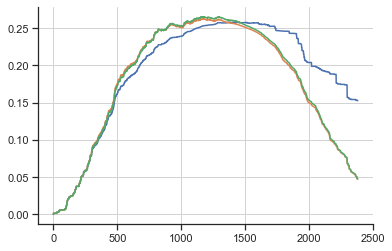

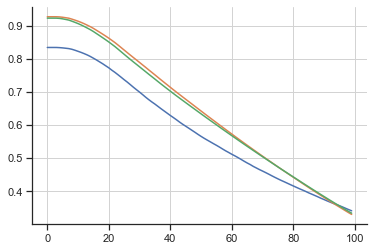

In [261]:
ibs_sf_ = metr.ibs_remain(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf1_ = metr.ibs_remain(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
ibs_sf2_ = metr.ibs_remain(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)

plt.plot(ibs_sf_)
plt.plot(ibs_sf1_)
plt.plot(ibs_sf2_)
plt.show()

auprc_sf_ = metr.auprc(y, y_, np.repeat(sf[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf1_ = metr.auprc(y, y_, np.repeat(sf1[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
auprc_sf2_ = metr.auprc(y, y_, np.repeat(sf2[np.newaxis, :], X_.shape[0], axis=0), bins_HO, axis=1)
plt.plot(auprc_sf_)
plt.plot(auprc_sf1_)
plt.plot(auprc_sf2_)
plt.show()

<Axes: >

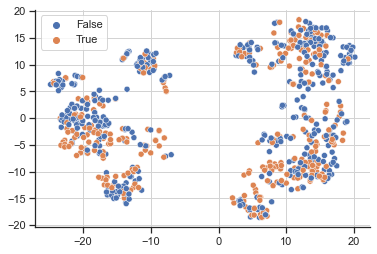

In [262]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X.fillna(X.median()))
X_embedded = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=42).fit_transform(X_scaled)
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1],
                hue=y["cens"])

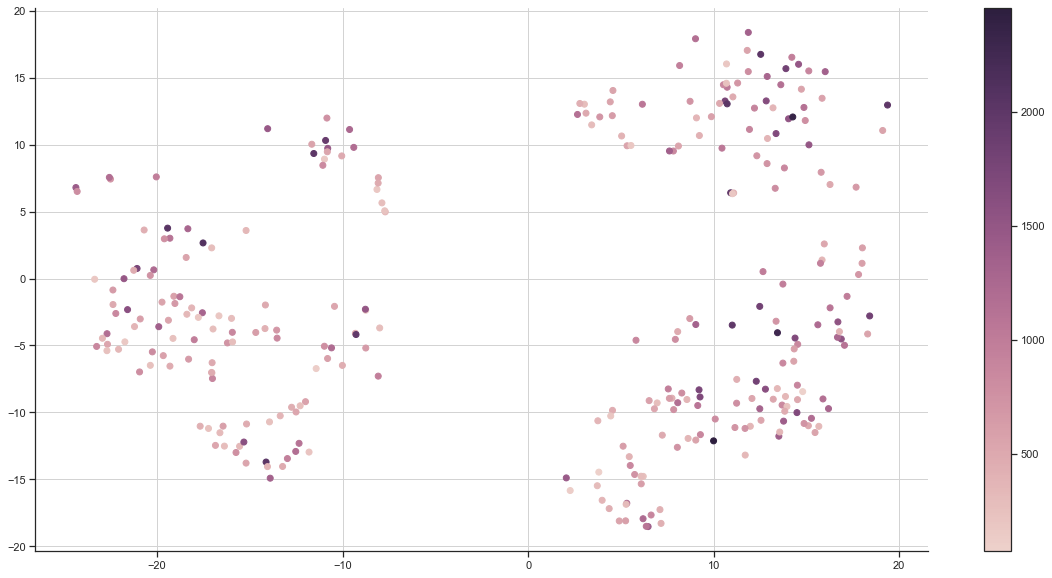

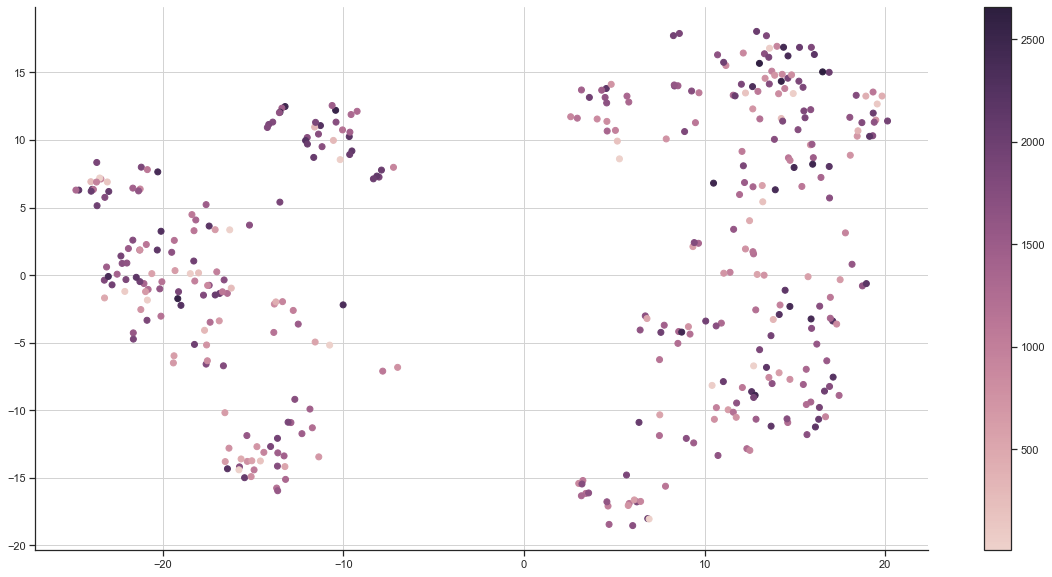

In [263]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 1)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

f, ax = plt.subplots(figsize=(20, 10))
ind = np.where(y["cens"] == 0)[0]
points = ax.scatter(x=X_embedded[ind, 0], y=X_embedded[ind, 1],
                c=y[ind]["time"], cmap=cmap)
f.colorbar(points)

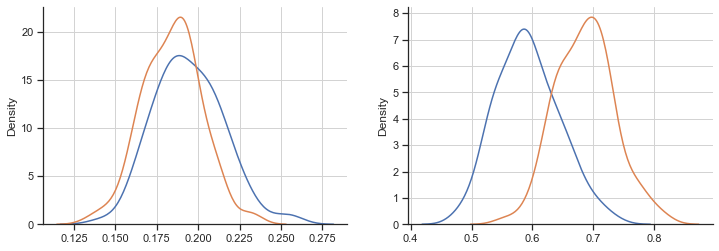

0.1944&0.1843&3.096e-04
0.5926&0.6865&2.403e-29


Text(0, 0.5, '$AUPRC$')

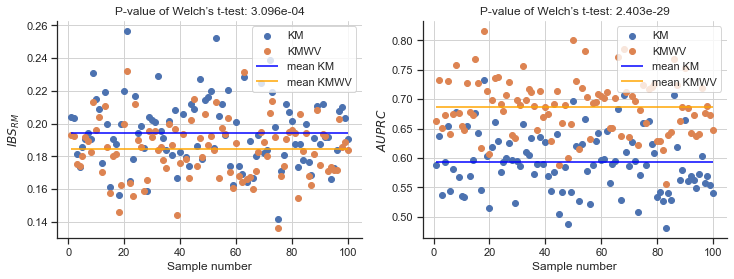

In [264]:
x = np.linspace(1, 100, 100)
ibs_1 = []
ibs_2 = []
auprc_1 = []
auprc_2 = []
np.random.seed(1)

for i, _ in enumerate(x):
    x_sub = df.sample(n=int(X.shape[0]*0.05), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
    time = x_sub["time"].to_numpy()
    cens = x_sub["cens"].to_numpy()
    
    bins_ = cnt.get_bins(time=time)
    y_v = cnt.get_y(cens=cens, time=time)
    
    km = KaplanMeierZeroAfter()
    km.fit(y_v["time"], y_v["cens"])
    sf = km.survival_function_at_times(bins_)

    km1 = KaplanMeierZeroAfterTh(stats.norm)
    km1.fit(y_v["time"], y_v["cens"])
    sf1 = km1.survival_function_at_times(bins_)

    ibs_1.append(metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    ibs_2.append(metr.ibs_remain(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

    auprc_1.append(metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_))
    auprc_2.append(metr.auprc(y_v, y_v, np.repeat(sf1[np.newaxis, :], y_v.shape[0], axis=0), bins_))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(ibs_1, ax=axes[0])
sns.kdeplot(ibs_2, ax=axes[0])

sns.kdeplot(auprc_1, ax=axes[1])
sns.kdeplot(auprc_2, ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(x, ibs_1, label="KM")
axes[0].scatter(x, ibs_2, label="KMWV")
axes[0].hlines([np.mean(ibs_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[0].hlines([np.mean(ibs_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[0].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
axes[0].legend()
axes[0].set_xlabel("Sample number")
axes[0].set_ylabel(r"$IBS_{RM}$")
print(f"{np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")

axes[1].scatter(x, auprc_1, label="KM")
axes[1].scatter(x, auprc_2, label="KMWV")
axes[1].hlines([np.mean(auprc_1)], xmin=min(x), xmax=max(x), color="blue", label="mean KM")
axes[1].hlines([np.mean(auprc_2)], xmin=min(x), xmax=max(x), color="orange", label="mean KMWV")
axes[1].set_title(f"P-value of Welch’s t-test: {stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
print(f"{np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")
axes[1].legend()

axes[1].set_xlabel("Sample number")
axes[1].set_ylabel(r"$AUPRC$")

In [265]:
from survivors.tree import CRAID

def split_by_tree(X, y, categ=[]):
    p = {'balance': None, 'categ': categ, 'criterion': 'peto', 'cut': False, 'depth': 5, 
         'leaf_model': 'base', 'min_samples_leaf': 0.02, 'signif': 0.05, 'woe': True}

    tree = CRAID(**p)
    tree.fit(X, y)
    return tree.predict(X, target="numb")
    

def print_metric_by_nonparam(df, subsample=0.3, prefix="", tree=False, categ=[]):
    ibs_1 = []
    ibs_2 = []
    auprc_1 = []
    auprc_2 = []
    np.random.seed(1)
    
    d = {}
    for i in range(int(1/subsample*5)):
        x_sub = df.sample(n=int(df.shape[0]*subsample), replace=True, random_state=i)  #  X.shape[0]*0.05, X.shape[0]*0.3
        time = x_sub["time"].to_numpy()
        cens = x_sub["cens"].to_numpy()

        bins_ = cnt.get_bins(time=time)
        y_src = cnt.get_y(cens=cens, time=time)
        
        strats = [y_src]
        
#         if tree:
#             X_ = x_sub[[c for c in x_sub.columns if not(c in ["time", "cens"])]]
#             nodes = split_by_tree(X_, y_src, categ=categ)
#             strats = [y_src[np.where(nodes == n)[0]] for n in set(nodes)]
#         print(len(strats))
        for y_v in strats:
            for th in ["", 2, 4, 6, stats.norm, TruncNorm, stats.lognorm, stats.gamma, stats.laplace, 
                       stats.laplace_asymmetric, stats.rayleigh, stats.weibull_min, stats.genlogistic]:
                if th == "":
                    suff = "km"
                    km = KaplanMeierZeroAfter()
                elif isinstance(th, int):
                    suff = f"Emp({th})"
                    km = KaplanMeierZeroAfterEmp(th)
                else:
                    suff = th._ctor_param["name"]
                    km = KaplanMeierZeroAfterTh(th)
                km.fit(y_v["time"], y_v["cens"])
                sf = km.survival_function_at_times(bins_)

                ibs_ = metr.ibs_remain(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                auprc_ = metr.auprc(y_v, y_v, np.repeat(sf[np.newaxis, :], y_v.shape[0], axis=0), bins_)
                if suff+"IBS" in d:
                    d[suff+"IBS"].append(ibs_)
                else:
                    d[suff+"IBS"] = [ibs_]
                if suff+"AUPRC" in d:
                    d[suff+"AUPRC"].append(auprc_)
                else:
                    d[suff+"AUPRC"] = [auprc_]
    
    d_ = {k: np.mean(v) for k, v in d.items()}
    d_["dataset"] = prefix
    d_["subsample"] = subsample
    return d_

#     print(f"{prefix + '|'}IBS:({subsample}): {np.mean(ibs_1):.4f}&{np.mean(ibs_2):.4f}&{stats.ttest_ind(ibs_1, ibs_2, equal_var=False).pvalue:.3e}")
#     print(f"{prefix + '|'}AUPRC({subsample}): {np.mean(auprc_1):.4f}&{np.mean(auprc_2):.4f}&{stats.ttest_ind(auprc_1, auprc_2, equal_var=False).pvalue:.3e}")

In [ ]:
from survivors.datasets import DATASETS_LOAD

l = []
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    X, y, features, categ, sch_nan = DATASETS_LOAD[ds_name]()
    bins_HO = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

    df = X.copy()
    df["time"] = y["time"]
    df["cens"] = y["cens"]
    
    for subsample in [1, 0.7, 0.5, 0.3, 0.1, 0.05]:
        d = print_metric_by_nonparam(df, subsample=subsample, prefix=ds_name, tree=True)
        l.append(d)
        print(d)
#     d = print_metric_by_nonparam(df, subsample=0.3, prefix=ds_name)
#     print(d)
#     l.append(d)
#     d = print_metric_by_nonparam(df, subsample=0.05, prefix=ds_name)
#     print(d)
#     l.append(d)
    
df_res = pd.DataFrame(l).T

{'kmIBS': 0.1845759382639201, 'kmAUPRC': 0.5896996848462435, 'Emp(2)IBS': 0.15811729873118996, 'Emp(2)AUPRC': 0.6883094383779976, 'Emp(4)IBS': 0.16432110471943825, 'Emp(4)AUPRC': 0.699022690681313, 'Emp(6)IBS': 0.17127967074751588, 'Emp(6)AUPRC': 0.700998351989563, 'normIBS': 0.16513360442620498, 'normAUPRC': 0.6791131393128613, 'TruncNormIBS': 0.16218821746008272, 'TruncNormAUPRC': 0.6667239080856237, 'lognormIBS': 0.160246225827597, 'lognormAUPRC': 0.6713122716233902, 'gammaIBS': 0.15952669546777484, 'gammaAUPRC': 0.6686125636560547, 'laplaceIBS': 0.1611188702261106, 'laplaceAUPRC': 0.677581152188106, 'laplace_asymmetricIBS': 0.15641569582692855, 'laplace_asymmetricAUPRC': 0.6608060318303066, 'rayleighIBS': 0.16102671335090885, 'rayleighAUPRC': 0.6705094793225448, 'weibull_minIBS': 0.16052331795297278, 'weibull_minAUPRC': 0.6691507617579632, 'genlogisticIBS': 0.15913690072013348, 'genlogisticAUPRC': 0.66917120476636, 'dataset': 'GBSG', 'subsample': 1}


In [ ]:
# df_res.to_csv("./ResultsTable.csv")

In [ ]:
df_

In [ ]:
for ds_name in ["GBSG", "PBC", "WUHAN", "rott2", "smarto", "support2"]:
    print(ds_name)
    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[:-2:2]:
        df_ = df_res.T
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], 1 - df_[c] / df_["kmIBS"], label=c)
    #plt.legend()
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

    plt.subplots(figsize=(10, 7))
    for c in df_res.T.columns[1:-2:2]:
        df_ = df_res.T
        df_ = df_[df_["dataset"] == ds_name]
        ls = '--' if (("km" in c) or ("norm" in c[:4])) else '-'
        plt.plot(df_["subsample"], df_[c], label=c, marker="<" if "Emp" in c else "o", linestyle=ls)
#         plt.plot(df_["subsample"], df_[c] / df_["kmAUPRC"] - 1, label=c)
    #plt.legend()
    plt.legend(loc="center right", bbox_to_anchor=(1.3, 0.5))
    plt.show()

In [ ]:
print(df_res.iloc[:-2:2].rank().mean(axis=1).sort_values())
print(df_res.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

for g in df_res.loc["dataset"].unique():
    print("="*10, g, "="*10)
    g_sample = (df_res.T[df_res.T["dataset"] == g]).T
    print(g_sample.iloc[:-2:2].rank().mean(axis=1).sort_values())
    print(g_sample.iloc[1:-2:2].rank(ascending=False).mean(axis=1).sort_values())

In [ ]:
df_ibs_rank = df_res.iloc[:-2:2].rank()
df_ibs_rank.index = df_ibs_rank.index.str[:-3]

df_auprc_rank = df_res.iloc[1:-2:2].rank(ascending=False)
df_auprc_rank.index = df_auprc_rank.index.str[:-5]

print(pd.concat([df_ibs_rank, df_auprc_rank], axis=1).mean(axis=1).sort_values())

In [ ]:
# IBS growth
1 - df_res.iloc[:-2:2] / df_res.iloc[[0]].values

In [ ]:
# AUPRC growth
df_res.iloc[1:-2:2] / df_res.iloc[[1]].values - 1